<h1>Finding suitable neighborhoods to set up coffee shops in Seattle</h1>

<p>Exploritory analysis to find neighborhoods that have relatively high number of food and beverage venues
(restaurants, bars etc) but a relatively low number of coffee venues(coffee shops and cafes)</p>

<h2>Part 1 Find Seattle neighborhoods that have a below average number of coffee venues</h2>
<ul>
    <li> Download list of seattle neighborhoods from wikipedia page and put into dataframe</li>
    <li> Add in coordinates to dataframe</li>
    <li> Get the coffee venues(coffee shops and cafes) for each neighborhood</li>
    <li> Determine the number of coffee venues in each neighborhood</li>
    <li> Get the average number coffee of coffee venues accross neighborhoods</li>
    <li> Find the neighborhoods that have a below average number of coffee venues</li>
</ul>

<h2>Part 2 Find the neighborhhoods where food and beverage venues are relatively common</h2>
<ul>
    <li>Get top 100 venues for each neighborhood</li>
    <li>Group by venue category cafe, coffee shop, chinese restaurant etc</li>
    <li>Get frequency of occurence for each venue category</li>
    <li>Get top 10 frequently occuring venue catagories for each neighborhood</li>
    <li>Separate neighborhoods into clusters using k-means clustering</li>
    <li>Determine which clusters may contain suitable neighborhoods for use in part 3</li>
</ul>
<h2>Part 3 Finding neighborhood that occur in both part1 and part2 resulting dataframes and narrowing down neighborhoods</h2>
<ul>
    <li>Take dataframe from part 1 and combine with the suitable cluster dataframes</li>
    <li>include only neighborhoods that occur in both the part 1 dataframe and cluster dataframes</li>
    <li>Use the resulting dataframes to select out suitable neighborhoods</li>
    
</ul>

<h1>Part 1:</h1>

In [16]:
# Imports
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
!pip -q install folium  
import folium # map rendering library
from pandas.io.json import json_normalize
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

<h3>Get list of Seattle neighborhoods from wikipedia using beautiful soup package</h3>

In [17]:
# download the wikipedia page data adn store it in a variable
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
# print(soup.prettify())


# Find the table on the wikipedia page and store it in a variable
right_table=soup.find('table', class_='wikitable sortable')
right_table

<table class="wikitable sortable" style="width:98%">
<tbody><tr>
<th width="2%">
</th>
<th width="12%">Neighborhood name
</th>
<th width="12%">Within larger district
</th>
<th width="7%">Annexed<sup class="reference" id="cite_ref-41"><a href="#cite_note-41">[41]</a></sup>
</th>
<th class="unsortable">Locator map
</th>
<th class="unsortable">Street map
</th>
<th class="unsortable">Image
</th>
<th class="unsortable">Notes
</th></tr>
<tr>
<th><small>1</small>
</th>
<td><b>North Seattle</b>
</td>
<td>Seattle
</td>
<td>Various
</td>
<td style="text-align:center;"><a class="image" href="/wiki/File:Norda_Seatlo.jpg"><img alt="Norda Seatlo.jpg" data-file-height="599" data-file-width="338" decoding="async" height="142" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Norda_Seatlo.jpg/80px-Norda_Seatlo.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Norda_Seatlo.jpg/120px-Norda_Seatlo.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Norda_Seatlo.jpg/160px-No

In [18]:
# loop through table to get the columns needed
A=[]
B=[]
for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==7:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        
        
# create dataframe with columns retrieved from table
seattle_neighbourhoods=pd.DataFrame(A,columns=['Neighborhood'])
seattle_neighbourhoods['District']=B
seattle_neighbourhoods

,Neighborhood,District
0,North Seattle,Seattle\n
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach,North Seattle
4,Crown Hill,North Seattle
...,...,...
122,Riverview,Delridge
123,Highland Park,Delridge
124,South Delridge,Delridge
125,Roxhill,Delridge


In [19]:
# striping new line characters from the new dataframe
seattle_neighbourhoods['Neighborhood'] = seattle_neighbourhoods['Neighborhood'].str.strip("\n")
seattle_neighbourhoods['District'] = seattle_neighbourhoods['District'].str.strip("\n")
# strip whitespace from column values
seattle_neighbourhoods['Neighborhood'] = seattle_neighbourhoods['Neighborhood'].str.strip()
seattle_neighbourhoods['District'] = seattle_neighbourhoods['District'].str.strip()

# add latitude and longitude columns to data frame
seattle_neighbourhoods['Latitude'] = ''
seattle_neighbourhoods['Longitude'] = ''
# remove first row in dataframe as it is the whole of north seattle not a neighborhood
seattle_neighbourhoods = seattle_neighbourhoods.iloc[1:]
seattle_neighbourhoods.head(5)

,Neighborhood,District,Latitude,Longitude
1,Broadview,North Seattle,,
2,Bitter Lake,North Seattle,,
3,North Beach,North Seattle,,
4,Crown Hill,North Seattle,,
5,Greenwood,North Seattle,,


<h3>Adding in coordinates for each of the neighborhoods to the seattle_neighbourhoods dataframe </h3>

In [20]:
# loop through each of the neighborhoods in dataframe and fill in latitude and logitude values for each neighborhood
# using geolocator if successfully finds address add coords to the dataframe otherwise add neighborhood name to the list missingVals
geolocator = Nominatim(user_agent="SE_explorer")
missingVals = []
count = 0
for row in seattle_neighbourhoods.iterrows():
    try:
        address = "{0}, {1}, Seattle, WA".format(row[1]["Neighborhood"],row[1]["District"])
        location = geolocator.geocode(address)
        row[1]["Latitude"] = str(location.latitude)
        row[1]["Longitude"] = str(location.longitude)
        count+=1;
    except:
        missingVals.append(row[1]["Neighborhood"])
    
print("coords fetched")

coords fetched


<h3>Coordinates not able to be fetched by geocoder, fetched manually and uploaded as a csv file</h3>

In [21]:
missingVals

['North College Park',
 'Olympic Hills',
 'Northlake',
 'Portage Bay',
 'Pike-Pine Corridor',
 'Interlaken',
 'Madison Valley',
 'Renton Hill',
 'Denny Triangle',
 'Belltown',
 'Pike-Market',
 'Central Business District',
 'First Hill',
 'Pioneer Square',
 'International District',
 'Yesler Terrace',
 'Central Waterfront',
 'West Edge',
 'Mann',
 'Cherry Hill',
 'Judkins Park',
 'Washington Park',
 'Mount Baker',
 'Mid Beacon Hill (Maplewood)',
 'Holly Park',
 'Industrial District',
 'SoDo',
 'Harbor Island',
 'Delridge',
 'Roxhill']

<h3>Adding in missing coords into a dataframe</h3>

In [22]:
# entered missing coordinates into a csv file 
# get missing coordinates csv file uploaded to watson studio
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f07d8d66c8d4416bafe41a013ab8989e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1GeYRyK1GJlGoVIDC5DewOp_h3WP0dFYwyvSlOooGjFv',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_f07d8d66c8d4416bafe41a013ab8989e.get_object(Bucket='capstone-donotdelete-pr-jbvw9dheitluxh',Key='MissingCoords.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

missing_coords = pd.read_csv(body)
missing_coords.head(5)

,Neighborhood,Latitude,Longitude
0,North College Park,47.701403,-122.335175
1,Meadowbrook,47.603230,-122.330280
2,Olympic Hills,47.726540,-122.301890
3,Northlake,47.654960,-122.320090
4,North Queen Anne,47.634010,-122.356980


In [23]:
# add in the missing coordinates into the seattle_neighborhoods dataframe
for row in seattle_neighbourhoods.iterrows():
    for row2 in missing_coords.iterrows():
        if row[1]["Neighborhood"] == row2[1]["Neighborhood"]:
            row[1]["Latitude"] = row2[1]["Latitude"]
            row[1]["Longitude"] = row2[1]["Longitude"]

In [25]:
seattle_neighbourhoods.head()

,Neighborhood,District,Latitude,Longitude
1,Broadview,North Seattle,47.7223199,-122.3604067
2,Bitter Lake,North Seattle,47.7262358,-122.3487639
3,North Beach,North Seattle,47.6962103,-122.392362
4,Crown Hill,North Seattle,47.6947154,-122.3714586
5,Greenwood,North Seattle,47.6909806,-122.3548773



<h3>Visualise neighborhoods on a map</h3>


In [26]:
# get seattle's coordinates for use in visualising the neighborhoods
address = "Seattle, WA"
# "Riverview, Delridge, Seattle, WA"

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seattle are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seattle are 47.6038321, -122.3300624.


In [27]:
# create the map
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(seattle_neighbourhoods['Latitude'], seattle_neighbourhoods['Longitude'], seattle_neighbourhoods['District'], seattle_neighbourhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

<h3>Visualise neighborhoods with 1km radius</h3>

In [28]:
# create the map
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(seattle_neighbourhoods['Latitude'], seattle_neighbourhoods['Longitude'], seattle_neighbourhoods['District'], seattle_neighbourhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
    folium.Circle([lat, lng],
                    radius=1000,
                    color='blue'
                   ).add_to(map_seattle)
    
map_seattle

<h3>There will be a fair amount of  overlap with neighborhoods that are close together, it is obviously not always a good as neighbrhoods are irregular shapes
which doesnt always fit with a circlar radius but in terms of space covered 1km radius seems to be a decent fit</h3>

<h3>Get coffee venues(coffee shops and cafes) for each neighborhood within 1km radius</h3>

In [85]:
# foursquare credentials
CLIENT_ID = 'M0PELKGFZ2NIYZ0C51Q2KLZ4MSAW0ZO0WJ1AOOJRHGHCG5FP' # your Foursquare ID
CLIENT_SECRET = 'MTPKX0LKQF1KELTFSZOC11043STK45T34SYJNGCBEJJNQAAW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
search_query= "coffee, cafe"

radius = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M0PELKGFZ2NIYZ0C51Q2KLZ4MSAW0ZO0WJ1AOOJRHGHCG5FP
CLIENT_SECRET:MTPKX0LKQF1KELTFSZOC11043STK45T34SYJNGCBEJJNQAAW


<h3>Modify the method from the New York Neighborhood Clustering lab to get coffee venues for each neighborhood in a 1 km radius</h3>

In [86]:
def getNearbyCoffeeShops(name, latitude, longitude, radius=1000):
    print(name)
    venues_list=[]
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
    results = requests.get(url).json()['response']['venues']
    
    venues_list.append([(
            name, 
            latitude, 
            longitude, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) 
            for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']

    return(nearby_venues)   

<h3>Create a new dataframe to hold the coffee venues for each neighborhood and</h3>
<h3>loop through the seattle neighborhoods dataframe and apply the above method</h3>

In [87]:
# create new dataframe to hold coffee venues for the neighborhoods
seattle_neighbourhoods_coffee_venues = pd.DataFrame(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'])
# list to hold names of the neighborhoods that didnt return any cofee venues
neighborhood_no_coffee_venues =[]
# loop through the seattle_neighborhoods dataframe and fetch to coffee venues for each neighborhood using above method
for row in seattle_neighbourhoods.iterrows():
    tempVenues = pd.DataFrame(None)
    try:
        tempVenues = getNearbyCoffeeShops(row[1]["Neighborhood"], row[1]["Latitude"], row[1]["Longitude"])
        seattle_neighbourhoods_coffee_venues = seattle_neighbourhoods_coffee_venues.append(tempVenues)
        
    except:
        neighborhood_no_coffee_venues.append(row[1]["Neighborhood"])
        print("No Venues")

Broadview
No Venues
Bitter Lake
North Beach
Crown Hill
Greenwood
Northgate
Haller Lake
Pinehurst
North College Park
Maple Leaf
Lake City
Cedar Park
Matthews Beach
Meadowbrook
Olympic Hills
Victory Heights
Wedgwood
View Ridge
Sand Point
Roosevelt
Ravenna
Bryant
Windermere
No Venues
Hawthorne Hills
Laurelhurst
University District
University Village
Wallingford
Northlake
Green Lake
Fremont
Phinney Ridge
Ballard
West Woodland
Whittier Heights
Adams
Sunset Hill
Loyal Heights
Central Seattle
Magnolia
Lawton Park
Briarcliff
Southeast Magnolia
Interbay
Queen Anne
North Queen Anne
East Queen Anne
Lower Queen Anne
West Queen Anne
Capitol Hill
Portage Bay
Broadway
Pike-Pine Corridor
Montlake
Stevens
Interlaken
Madison Valley
Renton Hill
Madison Park
Broadmoor
Lake Union
South Lake Union, Seattle
Cascade, Seattle
Westlake
Eastlake
Downtown
Denny Triangle
Belltown
Pike-Market
Central Business District
First Hill
Pioneer Square
International District
Yesler Terrace
Central Waterfront
West Edge
Centr

<h3>View the resulting dataframe</h3>

In [88]:
# sort the neighborhoods alphabetically
seattle_neighbourhoods_coffee_venues.sort_values('Neighborhood', ascending=True, inplace=True)
# reset the index
seattle_neighbourhoods_coffee_venues.reset_index(drop=True, inplace=True)
# check to the new dataframe
seattle_neighbourhoods_coffee_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Adams,47.67346645,-122.3915569,Ristorante Picolinos,47.675467,-122.398492
1,Adams,47.67346645,-122.3915569,Tripod Coffee,47.667761,-122.379023
2,Adams,47.67346645,-122.3915569,Flower Cafe,47.669306,-122.380347
3,Adams,47.67346645,-122.3915569,TranSlate Coffee,47.675881,-122.378667
4,Adams,47.67346645,-122.3915569,Kiss Cafe,47.668603,-122.393713


In [89]:
# check how many records have been returned
seattle_neighbourhoods_coffee_venues.shape

(2699, 6)

In [34]:
# neighborhoods didnt have any coffee venues in the specifyed radius
len(neighborhood_no_coffee_venues)

3

In [35]:
# the  venues that didn't have coffee venues in the specifyed radius
neighborhood_no_coffee_venues

['Broadview', 'Windermere', 'Rainier View']

<h3>Now to get the coffee venues count for each neighborhood</h3>

In [36]:
# temperary dataframe to get coffee venue count
seattle_coffee_count_per_neighborhood_temp = seattle_neighbourhoods_coffee_venues.groupby('Neighborhood').count()
seattle_coffee_count_per_neighborhood_temp[0:5]

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Neighborhood,,,,,
Adams,31,31,31,31,31
Alki Point,5,5,5,5,5
Arbor Heights,4,4,4,4,4
Atlantic,31,31,31,31,31
Ballard,35,35,35,35,35


In [37]:
# transfer count to new dataframe with neighborhood and coffee venue count columns
seattle_coffee_count_per_neighborhood = pd.DataFrame(columns=['Number of coffee venues'])
seattle_coffee_count_per_neighborhood['Number of coffee venues'] = seattle_coffee_count_per_neighborhood_temp['Venue']
seattle_coffee_count_per_neighborhood.head()

,Number of coffee venues
Neighborhood,
Adams,31
Alki Point,5
Arbor Heights,4
Atlantic,31
Ballard,35


<h3>Visualise the distribution of the number of coffee venues per neighborhood</h3>

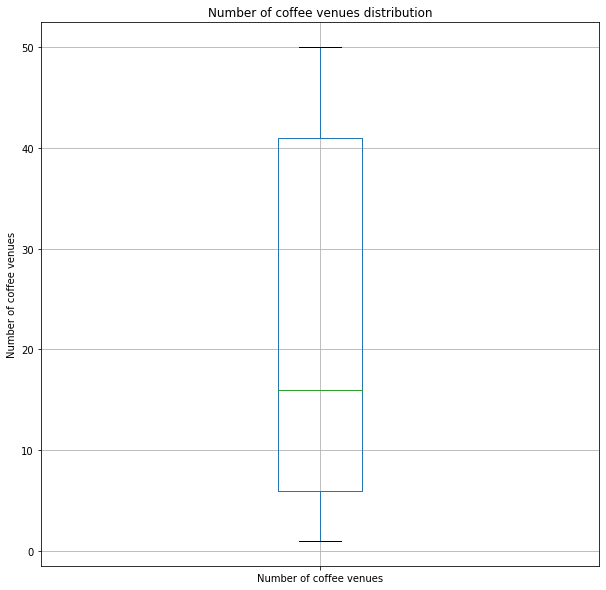

In [38]:
import matplotlib.pyplot as plt 
# looks like most of the values falls with 6 to 41 with a median of about 15
seattle_coffee_count_per_neighborhood.boxplot(column=['Number of coffee venues'], figsize = [10,10])
plt.title("Number of coffee venues distribution")
plt.ylabel("Number of coffee venues")
plt.xlabel("")
plt.show()

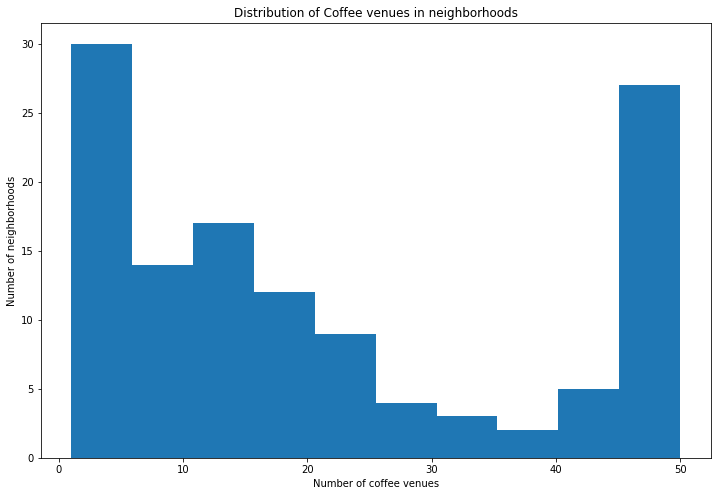

In [39]:
# looking at a histogram of the same data
# most of the neighborhoods seem to have coffee venue ranging
# in the region of 3 to 25 and 40 to 50

plt.figure(figsize=(12,8))
plt.hist(seattle_coffee_count_per_neighborhood['Number of coffee venues'])
plt.ylabel("Number of neighborhoods")
plt.xlabel("Number of coffee venues")
plt.title("Distribution of Coffee venues in neighborhoods")

plt.show()

<h3>Get the Median number of coffee venues per neighborhood</h3>

In [42]:
# the original idea was to get the neighborhood that had a below average number of coffee venues, that is
# had a number of coffee venues less than the mean but looking at the graphs above it seem that the data 
# is quite assymetrical, meaning that it has a high number of extrme values which  can skew that mean
#  so i will use the median number instead

# get the median of coffee venues 
median_coffee_venues = seattle_coffee_count_per_neighborhood['Number of coffee venues'].quantile(.5)
median_coffee_venues

16.0

<h3>Find the neighborhoods that have a number of coffee venues equal to or below the 25th percentile</h3>

In [43]:
below_median_coffee_venues = seattle_coffee_count_per_neighborhood[seattle_coffee_count_per_neighborhood['Number of coffee venues'] < median_coffee_venues] 
below_median_coffee_venues.shape

(61, 1)

In [44]:
# view the dataframe
below_median_coffee_venues.head(5)

,Number of coffee venues
Neighborhood,
Alki Point,5
Arbor Heights,4
Beacon Hill,14
Bitter Lake,10
Briarcliff,4


<h1>Part2: Find neighborhoods that have a relatively high number of food and beverage venues</h1>

<h3>Borrow the get_category_type method from the New York neighborhood clustering lab</h3>

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<h3>Loop through Seattle neighborhoods to get nearby venues in each neighborhood, limit 100</h3>

In [46]:
radius2 = 1000
# want to get all the venues in the specified radius but foursquare sets a limit of 100 so we'll go for the maximum
LIMIT2 = 100
column_names = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'name', 'categories', 'lat', 'lng']
# empty dataframes
seattle_neighbourhoods_top_100 = pd.DataFrame(columns=column_names)
temp_top100 = pd.DataFrame(columns=column_names)
# list to contain neighborhoods that return no values
missingVenues = []
# loop through each neighborhood in seattle_neighbourhoods dataframe and get top 100 venues
for row in seattle_neighbourhoods.iterrows():
#   clear dataframe and add in column headers
    temp_top100 = pd.DataFrame(columns = column_names)
    try:
        latitude2 = row[1]["Latitude"]
        longitude2 = row[1]["Longitude"]
        name2 = row[1]["Neighborhood"]
        url2 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude2, longitude2, VERSION, radius2, LIMIT2)
        results = requests.get(url2).json()
        
        venues = results['response']['groups'][0]['items']
    
        nearby_venues = json_normalize(venues) # flatten JSON

        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

        temp_top100 = temp_top100.append(nearby_venues)
        temp_top100['Neighborhood'] = name2
        temp_top100['Neighborhood Latitude'] = latitude2
        temp_top100['Neighborhood Longitude'] = longitude2
        seattle_neighbourhoods_top_100 = seattle_neighbourhoods_top_100.append(temp_top100)
        
    except:
        missingVenues.append(name2)
print("Top100 venues per neighborhood fetched")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Top100 venues per neighborhood fetched


In [47]:
# rename column headers
seattle_neighbourhoods_top_100.rename(columns = {'name':'Venue Name', 'categories':'Venue Category', 'lat': 'Venue Latitude', 'lng': 'Venue Longitude'}, inplace = True)
# sort the neighborhoods alphabetically
seattle_neighbourhoods_top_100.sort_values('Neighborhood', ascending=True, inplace=True)
# reset the index
seattle_neighbourhoods_top_100.reset_index(drop=True, inplace=True)

# check to dataframe
seattle_neighbourhoods_top_100.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Adams,47.67346645,-122.3915569,Olaf's,Bar,47.674712,-122.387815
1,Adams,47.67346645,-122.3915569,Pie Bar,Dessert Shop,47.668725,-122.385656
2,Adams,47.67346645,-122.3915569,Ballard Coffee Works,Coffee Shop,47.668853,-122.384716
3,Adams,47.67346645,-122.3915569,Ballard Farmer's Market,Farmers Market,47.667466,-122.384316
4,Adams,47.67346645,-122.3915569,Ballard Health Club,Gym,47.668841,-122.385025


In [48]:
# check how many venues have been returned
seattle_neighbourhoods_top_100.shape

(7499, 7)

In [49]:
# check what neighborhoods didnt return any values 
missingVenues

[]

<h3>Get venue count per neighborhood</h3>

In [50]:
# number of venues returned per neighborhood
top_100_count = seattle_neighbourhoods_top_100.groupby('Neighborhood').count()
top_100_count.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
Neighborhood,,,,,,
Adams,87,87,87,87,87,87
Alki Point,27,27,27,27,27,27
Arbor Heights,7,7,7,7,7,7
Atlantic,84,84,84,84,84,84
Ballard,100,100,100,100,100,100


In [51]:
# check how many separate venue categories there are
print('There are {} uniques categories.'.format(len(seattle_neighbourhoods_top_100['Venue Category'].unique())))

There are 374 uniques categories.


<h3>Preparing venue data for k-means clustering</h3>

<h3>Transforming the data with one hot encoding</h3>

In [52]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_neighbourhoods_top_100[['Venue Category']], prefix="", prefix_sep="")

seattle_onehot.drop('Neighborhood',axis=1, inplace=True)

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]
# add neighborhood column back to dataframe
seattle_onehot.insert(0, 'Neighborhood', seattle_neighbourhoods_top_100['Neighborhood'])

seattle_onehot.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# check how many record -sshould be the same as the top 100 dataframe
seattle_onehot.shape

(7499, 374)

<h3>Frequency of occurence of venues grouped by venue category in each neighborhood</h3>

In [54]:
# grouping the neighborhoods to get frequency of occurence of venues grouped by venue category type for each nieghborhood
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adams,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alki Point,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0
2,Arbor Heights,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0
3,Atlantic,0.0,0.00,0.0,0.011905,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0
4,Ballard,0.0,0.01,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.010000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,West Woodland,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.010000,0.0
122,Westlake,0.0,0.00,0.0,0.000000,0.01,0.020000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.010000,0.0
123,Whittier Heights,0.0,0.00,0.0,0.000000,0.00,0.011236,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.011236,0.0
124,Windermere,0.0,0.00,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0


<h3>Now to get the 10 most common venues for each neighborhood</h3>

In [55]:
# borrowing code from the new york lab again
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [56]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Burger Joint,Ice Cream Shop,Bar,Cocktail Bar,Coffee Shop,Mexican Restaurant,Park,Sushi Restaurant,Bakery,New American Restaurant
1,Alki Point,Beach,Coffee Shop,Art Gallery,History Museum,Baseball Stadium,Outdoor Sculpture,Donut Shop,Sandwich Place,Baseball Field,Scenic Lookout
2,Arbor Heights,Convenience Store,Park,Bowling Alley,Bus Stop,Construction & Landscaping,Home Service,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
3,Atlantic,Vietnamese Restaurant,Coffee Shop,Chinese Restaurant,Park,Asian Restaurant,Grocery Store,Pizza Place,BBQ Joint,Thrift / Vintage Store,Performing Arts Venue
4,Ballard,Coffee Shop,Ice Cream Shop,Bakery,Burger Joint,Thai Restaurant,Vietnamese Restaurant,Cocktail Bar,Gym,Bar,Dessert Shop


<h3>K-means Clustering</h3>
<h3>Now that we have the 10 most common venues, it's time to run k-means and separate neighborhoods into clusters</h3>

<h3>Separate neighborhoods into clusters</h3>

In [57]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 6

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 0, 2, 0, 2, 0, 4, 0], dtype=int32)

In [58]:
# neighborhoods_venues_sorted.drop('Cluster Labels',axis=1, inplace=True)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = neighborhoods_venues_sorted

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(seattle_neighbourhoods.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,2,Adams,Burger Joint,Ice Cream Shop,Bar,Cocktail Bar,Coffee Shop,Mexican Restaurant,Park,Sushi Restaurant,Bakery,New American Restaurant,Ballard,47.67346645,-122.3915569
1,2,Alki Point,Beach,Coffee Shop,Art Gallery,History Museum,Baseball Stadium,Outdoor Sculpture,Donut Shop,Sandwich Place,Baseball Field,Scenic Lookout,West Seattle,47.5762895,-122.4207968
2,1,Arbor Heights,Convenience Store,Park,Bowling Alley,Bus Stop,Construction & Landscaping,Home Service,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,West Seattle,47.512899,-122.3813585
3,0,Atlantic,Vietnamese Restaurant,Coffee Shop,Chinese Restaurant,Park,Asian Restaurant,Grocery Store,Pizza Place,BBQ Joint,Thrift / Vintage Store,Performing Arts Venue,Central Area,47.5972,-122.309
4,2,Ballard,Coffee Shop,Ice Cream Shop,Bakery,Burger Joint,Thai Restaurant,Vietnamese Restaurant,Cocktail Bar,Gym,Bar,Dessert Shop,North Seattle,47.6765073,-122.3862233


<h3>Visualise the numberhood clusters</h3>

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3>Examining the clusters</h3>

<h3>Cluster1</h3>

In [60]:
# This cluster seems a lot of food venues, seems suitable 
cluster1 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 0]
cluster1.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
3,0,Atlantic,Vietnamese Restaurant,Coffee Shop,Chinese Restaurant,Park,Asian Restaurant,Grocery Store,Pizza Place,BBQ Joint,Thrift / Vintage Store,Performing Arts Venue,Central Area,47.5972,-122.309
5,0,Beacon Hill,Coffee Shop,Pub,Bakery,Light Rail Station,Brewery,Fast Food Restaurant,Pizza Place,Playground,Pharmacy,Taco Place,South End,47.579257850000005,-122.31159768732729
7,0,Bitter Lake,Sushi Restaurant,Hotel,Fast Food Restaurant,Hobby Shop,Bakery,Automotive Shop,Thai Restaurant,Soccer Field,Athletics & Sports,Asian Restaurant,North Seattle,47.7262358,-122.3487639
9,0,Brighton,Vietnamese Restaurant,Convenience Store,Thai Restaurant,Café,Pub,Asian Restaurant,Bank,Fast Food Restaurant,Taco Place,Chinese Restaurant,Rainier Valley,47.5462102,-122.2756794
10,0,Broadmoor,Garden,Café,Park,Bar,Bank,Spa,Trail,Gas Station,Sushi Restaurant,Dry Cleaner,Madison Park,47.6351699,-122.2897114


<h3>Cluster2</h3>

In [61]:
# some restaurants but not quite enough
cluster2 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 1]
cluster2.head(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
2,1,Arbor Heights,Convenience Store,Park,Bowling Alley,Bus Stop,Construction & Landscaping,Home Service,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,West Seattle,47.512899,-122.3813585
24,1,Delridge,Convenience Store,Baseball Field,Park,Food Truck,Gas Station,Residential Building (Apartment / Condo),Dive Bar,Hardware Store,Bus Line,Zoo,West Seattle / South End,47.5355,-122.355
96,1,Riverview,Convenience Store,Coffee Shop,Park,Baseball Field,Sandwich Place,Dive Bar,Gas Station,Bus Line,Farmers Market,Falafel Restaurant,Delridge,47.539382700000004,-122.34918871766783


<h3>Cluster3</h3>

In [62]:
# good fit
cluster3 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 2]
cluster3.head(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,2,Adams,Burger Joint,Ice Cream Shop,Bar,Cocktail Bar,Coffee Shop,Mexican Restaurant,Park,Sushi Restaurant,Bakery,New American Restaurant,Ballard,47.67346645,-122.3915569
1,2,Alki Point,Beach,Coffee Shop,Art Gallery,History Museum,Baseball Stadium,Outdoor Sculpture,Donut Shop,Sandwich Place,Baseball Field,Scenic Lookout,West Seattle,47.5762895,-122.4207968
4,2,Ballard,Coffee Shop,Ice Cream Shop,Bakery,Burger Joint,Thai Restaurant,Vietnamese Restaurant,Cocktail Bar,Gym,Bar,Dessert Shop,North Seattle,47.6765073,-122.3862233
6,2,Belltown,Bar,Coffee Shop,Hotel,Sushi Restaurant,Pizza Place,Sculpture Garden,Bakery,Movie Theater,Gym,Scenic Lookout,Downtown,47.6166,-122.349
12,2,Broadway,Coffee Shop,Pizza Place,Cocktail Bar,Ramen Restaurant,Mexican Restaurant,Café,Ice Cream Shop,Sandwich Place,Thai Restaurant,Diner,Capitol Hill,47.6150562,-122.3208246
14,2,Capitol Hill,Coffee Shop,Cocktail Bar,American Restaurant,Bar,Bakery,Italian Restaurant,Thrift / Vintage Store,Garden,Yoga Studio,Indian Restaurant,Central Seattle,47.6238307,-122.3183689
15,2,"Cascade, Seattle",Coffee Shop,Café,Hotel,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Bakery,Steakhouse,Restaurant,South Lake Union,47.6203,-122.333
18,2,Central Business District,Hotel,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Italian Restaurant,Brewery,Sushi Restaurant,Grocery Store,Downtown,47.6095,-122.336
20,2,Central Waterfront,Coffee Shop,Brewery,Cocktail Bar,Mexican Restaurant,Bar,Sushi Restaurant,New American Restaurant,Ice Cream Shop,Sandwich Place,Pizza Place,Downtown,47.667,-122.381
21,2,Cherry Hill,Coffee Shop,Gay Bar,Burger Joint,Mexican Restaurant,French Restaurant,Donut Shop,Thai Restaurant,Bagel Shop,Ramen Restaurant,Ethiopian Restaurant,Minor,47.609,-122.309


<h3>Cluster4</h3>

In [63]:
# not suitable
cluster4 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 3]
cluster4.head(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
124,3,Windermere,Bus Stop,Greek Restaurant,Park,Bank,Trail,Automotive Shop,Pizza Place,Indie Movie Theater,Beach,Food Truck,North Seattle,47.6709318,-122.2617917


<h3>Cluster5</h3>

In [64]:
# some of food venues and open public spaces
cluster5 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 4]
cluster5.head(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
8,4,Briarcliff,Park,Playground,Trail,Grocery Store,Pool,Breakfast Spot,Athletics & Sports,Coffee Shop,Video Store,Bus Stop,Magnolia,47.6481511,-122.40761211983732
31,4,Fauntleroy,Boat or Ferry,Park,Playground,Pier,Pilates Studio,Market,Beach,Bus Station,Scenic Lookout,American Restaurant,West Seattle,47.5223995,-122.3934168
34,4,Gatewood,Park,Pizza Place,Coffee Shop,Bar,Building,Beer Store,Japanese Restaurant,Optical Shop,Gas Station,Bank,West Seattle,47.5365596,-122.385326
43,4,High Point,Park,Gas Station,Gym / Fitness Center,Storage Facility,Trail,Restaurant,Asian Restaurant,Furniture / Home Store,Food Truck,Rental Car Location,Delridge,47.54992165,-122.37318776354516
44,4,Highland Park,Gas Station,Park,Garden,Convenience Store,Vietnamese Restaurant,Trail,Bus Station,Restaurant,Bakery,Coffee Shop,Delridge,47.5521233,-122.3638741
55,4,Lakewood,Park,Harbor / Marina,Lake,Pet Store,Beach,Organic Grocery,Café,Dog Run,Restaurant,Grocery Store,Seward Park,47.5632,-122.272
57,4,Lawton Park,Park,Trail,Coffee Shop,Brewery,Breakfast Spot,Grocery Store,Greek Restaurant,Bus Stop,Japanese Restaurant,Chiropractor,Magnolia,47.6563294,-122.4002959
68,4,Matthews Beach,Trail,Park,Golf Course,Playground,Locksmith,Zoo,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Lake City,47.69692655,-122.27272363041745
75,4,North Beach,Beach,Park,Trail,Construction & Landscaping,Coffee Shop,Dog Run,Gluten-free Restaurant,Athletics & Sports,Mexican Restaurant,Playground,North Seattle,47.6962103,-122.392362
78,4,North Delridge,Garden,Park,Gas Station,Soccer Field,Restaurant,Trail,Vietnamese Restaurant,Coffee Shop,Campground,Bus Station,Delridge,47.555064200000004,-122.3637181


<h3>Cluster6</h3>

In [65]:
# not really suitable
cluster6 = seattle_merged.loc[seattle_merged['Cluster Labels'] == 5]
cluster6.head(50)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
93,5,Rainier View,Bakery,Gun Range,Lounge,Zoo,Dry Cleaner,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Rainier Valley,47.5038,-122.26


<h1>Part 3: Finding neighborhoods that are have a relatively low number of coffee venues and relatively high number of food and beverage venues</h1>

<ul style="font-size: 17px">
<li>Now that the neighborhoods have been seperated into clusters it time to pick which clusters look promising.</li>
<li > Clusters 1 and 3 seem to have a fair amount of food and beverage venues.</li>
<li> Lets see which a those neighborhoods in these clusters have a coffee venue count equal to or below the threshold by filtering the clusters</li>
</ul>


<h3>Filtering the clusters</h3>

<h4>Now that appropriate clusters have been identified it time to see which neighborhoods occur in both these cluster and the coffee venue dataframe from part 1</h4>

In [66]:
cluster1_filtered = pd.merge(below_median_coffee_venues, cluster1, left_index=True, right_on='Neighborhood', how= 'inner')
cluster1_filtered.reset_index(drop=True, inplace=True)
cluster1_filtered.head(50)

,Number of coffee venues,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,14,0,Beacon Hill,Coffee Shop,Pub,Bakery,Light Rail Station,Brewery,Fast Food Restaurant,Pizza Place,Playground,Pharmacy,Taco Place,South End,47.579257850000005,-122.31159768732729
1,10,0,Bitter Lake,Sushi Restaurant,Hotel,Fast Food Restaurant,Hobby Shop,Bakery,Automotive Shop,Thai Restaurant,Soccer Field,Athletics & Sports,Asian Restaurant,North Seattle,47.7262358,-122.3487639
2,6,0,Broadmoor,Garden,Café,Park,Bar,Bank,Spa,Trail,Gas Station,Sushi Restaurant,Dry Cleaner,Madison Park,47.6351699,-122.2897114
3,7,0,Bryant,Café,Chinese Restaurant,Grocery Store,Pizza Place,Coffee Shop,Donut Shop,Organic Grocery,Seafood Restaurant,Electronics Store,Park,North Seattle,47.6752333,-122.28349345639771
4,3,0,Cedar Park,Trail,Vietnamese Restaurant,Pharmacy,Bank,Sushi Restaurant,Supermarket,Thai Restaurant,Brewery,Dog Run,Noodle House,Lake City,47.7256535,-122.2859597
5,15,0,Columbia City,Park,Pizza Place,Ethiopian Restaurant,Ice Cream Shop,Pub,Soccer Field,Bar,Mexican Restaurant,Bakery,Convenience Store,Rainier Valley,47.5579124,-122.2852162
6,8,0,Dunlap,Mexican Restaurant,Grocery Store,Coffee Shop,Light Rail Station,Food,Tennis Court,Garden,Beach,Furniture / Home Store,Liquor Store,Rainier Valley,47.5266924,-122.2707327507129
7,9,0,Haller Lake,Vietnamese Restaurant,ATM,Fast Food Restaurant,Automotive Shop,Marijuana Dispensary,Bakery,Chinese Restaurant,Gas Station,Coffee Shop,Hardware Store,Northgate,47.7197478,-122.33375132229858
8,4,0,Harbor Island,Harbor / Marina,Business Service,Boat or Ferry,Train Station,Deli / Bodega,Fair,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Industrial District,47.5791,-122.351
9,1,0,Hawthorne Hills,Greek Restaurant,Market,Lawyer,Bank,Dry Cleaner,Playground,American Restaurant,Pizza Place,Café,Beach,Windermere,47.6701447,-122.2708627


In [67]:
cluster3_filtered = pd.merge(below_median_coffee_venues, cluster3, left_index=True, right_on='Neighborhood', how= 'inner')
cluster3_filtered.reset_index(drop=True, inplace=True)
cluster3_filtered.head(50)

,Number of coffee venues,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,5,2,Alki Point,Beach,Coffee Shop,Art Gallery,History Museum,Baseball Stadium,Outdoor Sculpture,Donut Shop,Sandwich Place,Baseball Field,Scenic Lookout,West Seattle,47.5762895,-122.4207968
1,11,2,Crown Hill,Pizza Place,Food Truck,Coffee Shop,Mexican Restaurant,Asian Restaurant,Pet Store,Supermarket,Breakfast Spot,Grocery Store,Greek Restaurant,North Seattle,47.6947154,-122.3714586
2,14,2,Fairmount Park,Coffee Shop,Park,Pub,Pizza Place,American Restaurant,Arts & Crafts Store,Grocery Store,Pet Store,Scenic Lookout,Convenience Store,West Seattle,47.579851250000004,-122.3822514061129
3,15,2,Genesee,Coffee Shop,Pizza Place,Gym,Burger Joint,Furniture / Home Store,Mexican Restaurant,Brewery,Asian Restaurant,American Restaurant,BBQ Joint,West Seattle,47.56457515,-122.38451277378597
4,15,2,Greenwood,Coffee Shop,Mexican Restaurant,Pizza Place,Bar,Mediterranean Restaurant,Greek Restaurant,Chinese Restaurant,Automotive Shop,Spa,Playground,North Seattle,47.6909806,-122.3548773
5,11,2,North Admiral,Coffee Shop,Pizza Place,Park,Beach,Pub,Pet Store,American Restaurant,Café,Convenience Store,Grocery Store,West Seattle,47.5811953,-122.3865457
6,15,2,South End,Clothing Store,Coffee Shop,Furniture / Home Store,Italian Restaurant,Women's Store,Cosmetics Shop,Pizza Place,Arts & Crafts Store,New American Restaurant,Mobile Phone Shop,Seattle,47.66036305,-122.29111862731729
7,5,2,South Park,Mexican Restaurant,Park,Bar,Brewery,Pizza Place,Coffee Shop,Shipping Store,Café,Grocery Store,Library,South End,47.5265,-122.324


In [68]:
cluster5_filtered = pd.merge(below_median_coffee_venues, cluster5, left_index=True, right_on='Neighborhood', how= 'inner')
cluster5_filtered.reset_index(drop=True, inplace=True)
cluster5_filtered.head()

,Number of coffee venues,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,4,4,Briarcliff,Park,Playground,Trail,Grocery Store,Pool,Breakfast Spot,Athletics & Sports,Coffee Shop,Video Store,Bus Stop,Magnolia,47.6481511,-122.40761211983732
1,2,4,Fauntleroy,Boat or Ferry,Park,Playground,Pier,Pilates Studio,Market,Beach,Bus Station,Scenic Lookout,American Restaurant,West Seattle,47.5223995,-122.3934168
2,5,4,Gatewood,Park,Pizza Place,Coffee Shop,Bar,Building,Beer Store,Japanese Restaurant,Optical Shop,Gas Station,Bank,West Seattle,47.5365596,-122.385326
3,8,4,High Point,Park,Gas Station,Gym / Fitness Center,Storage Facility,Trail,Restaurant,Asian Restaurant,Furniture / Home Store,Food Truck,Rental Car Location,Delridge,47.54992165,-122.37318776354516
4,4,4,Highland Park,Gas Station,Park,Garden,Convenience Store,Vietnamese Restaurant,Trail,Bus Station,Restaurant,Bakery,Coffee Shop,Delridge,47.5521233,-122.3638741


<h2>Selecting suitable neighborhoods from filtered clusters</h2>

<h3>Venues that will be considered:</h3> 
<ul style="font-size: 17px">
    <li>Neighborhoods that have 2 restaurants in the top 4 most common venues</li>
    <li>Neighborhoods that have at least 5 food and/or beverage venues(excluding coffee shops and cafes) in the top 10</li>
</ul>



In [69]:
# cluster 1 and 3 have suitable neighborhoods, but not cluster 5
# create dataframe to hold suitable neighborhoods
suitable_neighborhoods  = pd.DataFrame() 

# getting neighborhoods from cluster 1 filtered
for row in cluster1_filtered.iterrows():
    index = row[0]
    if(index == 5 or index == 10 or index == 13 or index == 23 or index == 26):
        suitable_neighborhoods = suitable_neighborhoods.append(row[1])    
        
# getting neighborhoods from cluster 3 filtered
suitable_neighborhoods = suitable_neighborhoods.append(cluster3_filtered.iloc[3]) 
suitable_neighborhoods = suitable_neighborhoods.append(cluster3_filtered.iloc[4]) 

suitable_neighborhoods = suitable_neighborhoods.reindex(cluster1_filtered.columns, axis=1)
suitable_neighborhoods.sort_values('Neighborhood', ascending=True, inplace=True)
suitable_neighborhoods.reset_index(drop=True, inplace=True)
suitable_neighborhoods['Number of coffee venues'] = suitable_neighborhoods['Number of coffee venues'].astype(int)
suitable_neighborhoods['Cluster Labels'] = suitable_neighborhoods['Cluster Labels'].astype(int)

<h2>The final dataframe containing suitable neighborhoods</h2>
<h3>These are the neighborhoods that have met all the requirements of the analysis</h3>

In [70]:
suitable_neighborhoods.head(10)

,Number of coffee venues,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Latitude,Longitude
0,15,0,Columbia City,Park,Pizza Place,Ethiopian Restaurant,Ice Cream Shop,Pub,Soccer Field,Bar,Mexican Restaurant,Bakery,Convenience Store,Rainier Valley,47.5579124,-122.2852162
1,15,2,Genesee,Coffee Shop,Pizza Place,Gym,Burger Joint,Furniture / Home Store,Mexican Restaurant,Brewery,Asian Restaurant,American Restaurant,BBQ Joint,West Seattle,47.56457515,-122.38451277378597
2,15,2,Greenwood,Coffee Shop,Mexican Restaurant,Pizza Place,Bar,Mediterranean Restaurant,Greek Restaurant,Chinese Restaurant,Automotive Shop,Spa,Playground,North Seattle,47.6909806,-122.3548773
3,13,0,Holly Park,Vietnamese Restaurant,Grocery Store,Chinese Restaurant,Mexican Restaurant,Convenience Store,Coffee Shop,Pizza Place,Cajun / Creole Restaurant,Bakery,Bank,Beacon Hill,47.5389,-122.286
4,3,0,Lake City,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Bank,Gas Station,Sushi Restaurant,Thai Restaurant,Breakfast Spot,Café,Bakery,North Seattle,47.7191619,-122.2954939
5,4,0,Olympic Hills,Bus Station,Thai Restaurant,Bank,Chinese Restaurant,Gymnastics Gym,Vietnamese Restaurant,Bar,Beer Store,Mexican Restaurant,Gaming Cafe,Lake City,47.7265,-122.302
6,9,0,Renton Hill,Pizza Place,Vietnamese Restaurant,Coffee Shop,Post Office,Japanese Restaurant,BBQ Joint,Thai Restaurant,Bank,Szechuan Restaurant,Food Truck,Capitol Hill / Stevens,47.5713,-122.297


In [71]:
# get coffee venues for suiable neighborhoods to display on map
suitable_neighborhoods_coffee = seattle_neighbourhoods_coffee_venues.loc[seattle_neighbourhoods_coffee_venues['Neighborhood'].isin(suitable_neighborhoods['Neighborhood'])]

suitable_neighborhoods_coffee.head()                                                                

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
609,Columbia City,47.5579124,-122.2852162,Olympia Coffee,47.558823,-122.285259
610,Columbia City,47.5579124,-122.2852162,Coffeeholic House,47.557157,-122.285951
611,Columbia City,47.5579124,-122.2852162,Nasjib Cafe,47.553255,-122.278913
612,Columbia City,47.5579124,-122.2852162,Taproot Cafe & Bar,47.557613,-122.284570
613,Columbia City,47.5579124,-122.2852162,Columbia City Suds,47.557647,-122.285364


In [72]:
# get top 100 venues for suitable neighborhoods to display on map
suitable_neighborhoods_top100 = seattle_neighbourhoods_top_100.loc[seattle_neighbourhoods_top_100['Neighborhood'].isin(suitable_neighborhoods['Neighborhood'])]
suitable_neighborhoods_top100[0:5]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
1483,Columbia City,47.5579124,-122.2852162,Subway,Sandwich Place,47.558709,-122.285491
1484,Columbia City,47.5579124,-122.2852162,Jus Bar,Juice Bar,47.557638,-122.284852
1485,Columbia City,47.5579124,-122.2852162,Redbox,Video Store,47.563616,-122.287353
1486,Columbia City,47.5579124,-122.2852162,Pawn X Change,Pawn Shop,47.550475,-122.287254
1487,Columbia City,47.5579124,-122.2852162,Providence ElderPlace - Seattle,Medical Center,47.562104,-122.294539


<h3>Visualise neighborhoods(blue), the nearby coffee venues(red) and top100 venues(green) on a map</h3>

In [74]:
# create the map
map_suitable_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(suitable_neighborhoods['Latitude'], suitable_neighborhoods['Longitude'], suitable_neighborhoods['District'], suitable_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_suitable_neighborhoods)  

    # add top 100 venues
    for row2 in suitable_neighborhoods_top100.iterrows():
        label100 = '{}, {}'.format(row2[1]['Venue Name'], row2[1]['Venue Category'])
        label100 = folium.Popup(label100, parse_html=True)

        if(neighborhood == row2[1]['Neighborhood']):
            folium.CircleMarker(
                [row2[1]['Venue Latitude'], row2[1]['Venue Longitude']],
                radius=5,
                popup=label100,
                color='green',
                fill=True,
                fill_color='#94CE9D',
                fill_opacity=0.7,
                parse_html=False).add_to(map_suitable_neighborhoods)
    
    # add coffee venues
    for row in suitable_neighborhoods_coffee.iterrows():
        labelcof = '{}'.format(row[1]['Venue'])
        labelcof = folium.Popup(labelcof, parse_html=True)

        if(neighborhood == row[1]['Neighborhood']):
            folium.CircleMarker(
                [row[1]['Venue Latitude'], row[1]['Venue Longitude']],
                radius=5,
                popup=labelcof,
                color='brown',
                fill=True,
                fill_color='#D3AC9E',
                fill_opacity=0.7,
                parse_html=False).add_to(map_suitable_neighborhoods)


    

    
    
    
map_suitable_neighborhoods